In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

In [13]:
df = pd.read_csv("CVHS.csv")

In [14]:
df.head(20)

,Unnamed: 0,subject,time_sec,ecg,eda_chest,resp,temp_chest,bvp,eda_wrist,temp_wrist,cvhs
0,0,S10,0,0.008149,0.721656,-0.885668,33.730853,10.416406,0.345697,33.1525,0.566714
1,1,S10,1,0.115067,0.723770,-2.308350,33.732074,-13.630313,0.336743,33.1525,0.562717
2,2,S10,2,-0.030732,0.722965,0.359229,33.732405,5.570469,0.336103,33.1575,0.559000
3,3,S10,3,0.008302,0.724669,-0.478616,33.733954,1.118594,0.336103,33.1525,0.558517
4,4,S10,4,-0.029259,0.722941,-0.226955,33.735060,-3.273438,0.335144,33.1575,0.562225
5,5,S10,5,0.006731,0.724384,1.153800,33.737312,1.631094,0.334504,33.1600,0.568666
6,6,S10,6,0.010648,0.724842,2.246172,33.740408,-37.143906,0.338981,33.1375,0.568024
7,7,S10,7,-0.020502,0.724613,0.425432,33.744416,23.605156,0.342179,33.1300,0.570067
8,8,S10,8,0.002867,0.724174,-0.702262,33.745871,30.667031,0.344737,33.1300,0.571215
9,9,S10,9,0.001370,0.725488,-2.302220,33.743608,11.030781,0.346017,33.1450,0.575813


In [15]:
df.shape

(86868, 11)

In [16]:
df = df.drop(columns=['Unnamed: 0'])

In [17]:
le = LabelEncoder()
df['subject'] = le.fit_transform(df['subject'])  # S10->0, S11->1, etc.


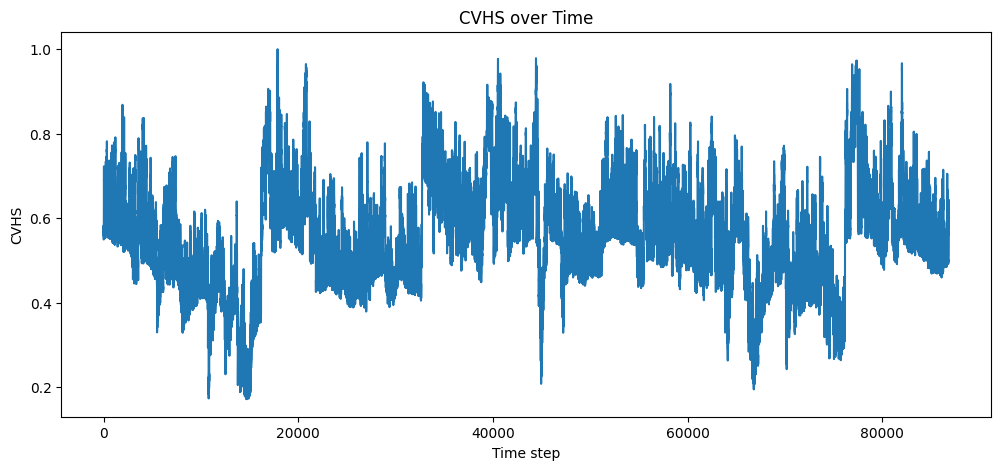

In [18]:
# 3. Data visualization
plt.figure(figsize=(12,5))
plt.plot(df['cvhs'])
plt.title('CVHS over Time')
plt.xlabel('Time step')
plt.ylabel('CVHS')
plt.show()

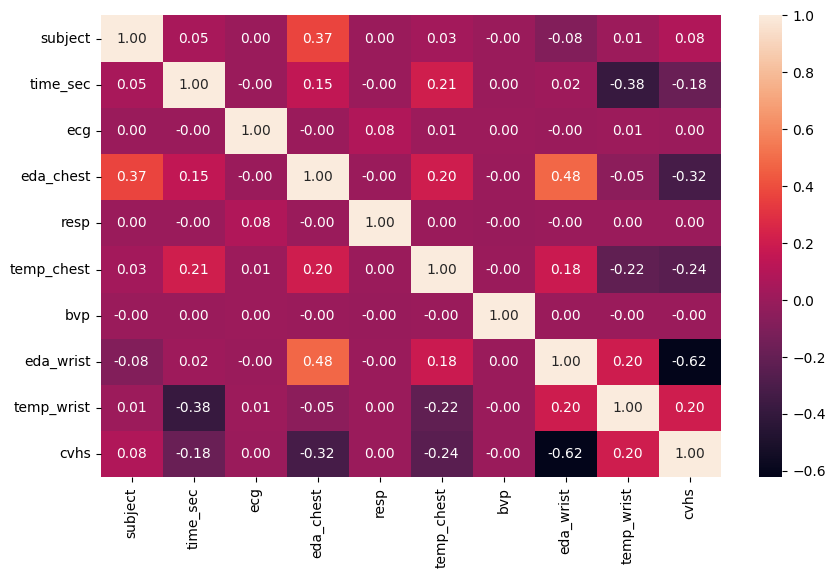

In [19]:
# Correlation heatmap
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), annot=True, fmt=".2f")
plt.show()

In [20]:
df.ffill(inplace=True)

In [21]:
features = ['ecg','eda_wrist','resp','temp_wrist','bvp']
target = 'cvhs'

In [22]:
# Standardize
scaler = StandardScaler()
df[features] = scaler.fit_transform(df[features])

In [23]:
# 5. Windowing: 1 min windows with 50% overlap
# -------------------------
window_size = 60  # 60 sec
step_size = 30    # 50% overlap

X_windows = []
y_windows = []

for i in range(0, len(df) - window_size + 1, step_size):
    window = df[features].iloc[i:i+window_size].values
    target_window = df[target].iloc[i:i+window_size].mean()  # average cvhs
    X_windows.append(window)
    y_windows.append(target_window)

X_windows = np.array(X_windows)
y_windows = np.array(y_windows)

print("X shape:", X_windows.shape)
print("y shape:", y_windows.shape)

X shape: (2894, 60, 5)
y shape: (2894,)


In [24]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv1D, BatchNormalization, Dropout, LSTM,
    Dense, Multiply, Lambda, Softmax
)
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# ---------- ATTENTION BLOCK ----------
def attention_block(inputs):
    attn_scores = Dense(1, activation='tanh')(inputs)
    attn_scores = Softmax(axis=1)(attn_scores)  # normalize over time
    context_vector = Multiply()([inputs, attn_scores])
    context_vector = Lambda(lambda x: K.sum(x, axis=1))(context_vector)
    return context_vector

# ---------- MODEL ----------
input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))

x = Conv1D(64, 3, activation='relu', padding='same')(input_layer)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Conv1D(32, 3, activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = LSTM(64, return_sequences=True)(x)

x = attention_block(x)
output = Dense(1)(x)

model = Model(inputs=input_layer, outputs=output)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 60, 5)]              0         []                            
                                                                                                  
 conv1d_2 (Conv1D)           (None, 60, 64)               1024      ['input_1[0][0]']             
                                                                                                  
 batch_normalization_2 (Bat  (None, 60, 64)               256       ['conv1d_2[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 dropout_1 (Dropout)         (None, 60, 64)               0         ['batch_normalization_2[0]

In [25]:
from sklearn.model_selection import train_test_split

# Split into train (70%), validation (15%), test (15%)
X_train, X_temp, y_train, y_temp = train_test_split(X_windows, y_windows, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print("Train:", X_train.shape)
print("Val:", X_val.shape)
print("Test:", X_test.shape)


Train: (2025, 60, 5)
Val: (434, 60, 5)
Test: (435, 60, 5)


In [26]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/50


64/64 [==============================] - 6s 52ms/step - loss: 0.0260 - mae: 0.1068 - val_loss: 0.0580 - val_mae: 0.2288
Epoch 2/50
64/64 [==============================] - 3s 41ms/step - loss: 0.0052 - mae: 0.0562 - val_loss: 0.0102 - val_mae: 0.0792
Epoch 3/50
64/64 [==============================] - 2s 39ms/step - loss: 0.0049 - mae: 0.0551 - val_loss: 0.0049 - val_mae: 0.0547
Epoch 4/50
64/64 [==============================] - 3s 42ms/step - loss: 0.0047 - mae: 0.0546 - val_loss: 0.0043 - val_mae: 0.0532
Epoch 5/50
64/64 [==============================] - 2s 39ms/step - loss: 0.0044 - mae: 0.0515 - val_loss: 0.0061 - val_mae: 0.0645
Epoch 6/50
64/64 [==============================] - 3s 43ms/step - loss: 0.0042 - mae: 0.0508 - val_loss: 0.0040 - val_mae: 0.0520
Epoch 7/50
64/64 [==============================] - 3s 42ms/step - loss: 0.0036 - mae: 0.0474 - val_loss: 0.0032 - val_mae: 0.0460
Epoch 8/50
64/64 [==============================] - 3s 42ms/step - loss: 0.0035 -

In [27]:
# Evaluate on the test set
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=1)
print(f"✅ Test Loss (MSE): {test_loss:.4f}")
print(f"✅ Test MAE: {test_mae:.4f}")

# Predict
y_pred = model.predict(X_test)


14/14 [==============================] - 0s 10ms/step - loss: 0.0019 - mae: 0.0346
✅ Test Loss (MSE): 0.0019
✅ Test MAE: 0.0346
14/14 [==============================] - 1s 9ms/step


In [28]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("📈 MAE:", round(mae, 4))
print("📉 RMSE:", round(rmse, 4))
print("🔹 R²:", round(r2, 4))


📈 MAE: 0.0346
📉 RMSE: 0.0438
🔹 R²: 0.8737


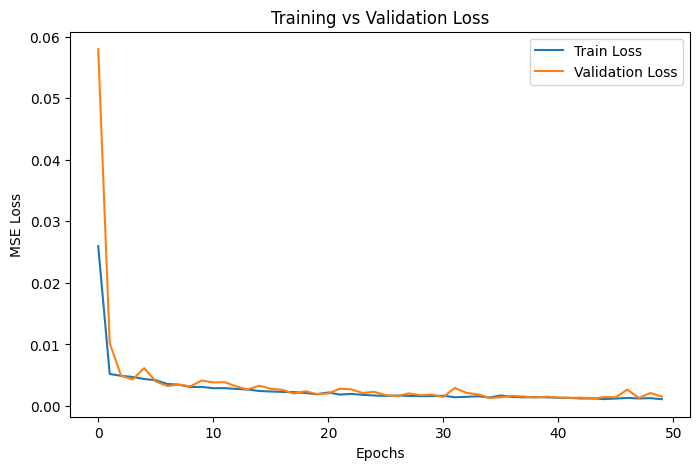

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.title('Training vs Validation Loss')
plt.show()


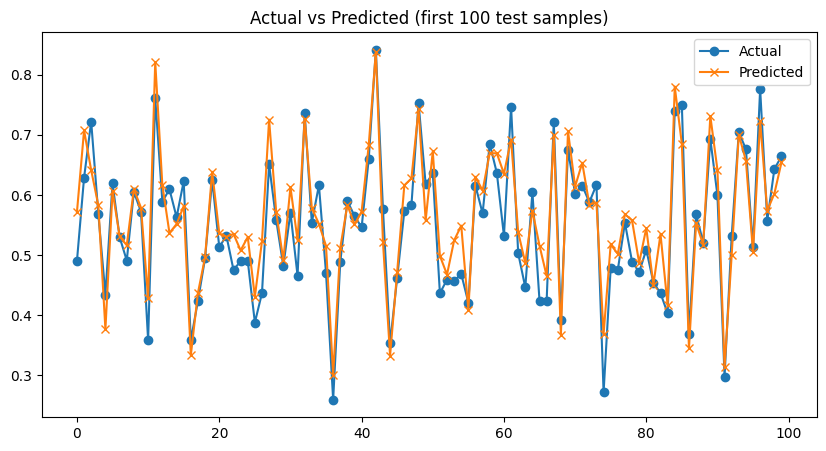

In [30]:
plt.figure(figsize=(10,5))
plt.plot(y_test[:100], label='Actual', marker='o')
plt.plot(y_pred[:100], label='Predicted', marker='x')
plt.legend()
plt.title('Actual vs Predicted (first 100 test samples)')
plt.show()


In [31]:
model.save("cvhs_v2.keras")
print("Model saved successfully!")

Model saved successfully!
